# Introduction to Notebooks and PyTorch.

---


# Keywords: tensor, function, computational graph, gradient, backward propagation

## Test hardware

In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
# !conda install pytorch torchvision cudatoolkit=10.1 -c pytorch -c defaults -c conda-forge

## Main concepts

#### Tensors
Tensors - objects and results of any computations.

In [4]:
x = torch.tensor([1.0, 2.0])
x

tensor([1., 2.])

In [5]:
torch.zeros((1, 1))

tensor([[0.]])

In [6]:
torch.ones(3)

tensor([1., 1., 1.])

#### Computational graph. 


Functions and tensors can be used to build a computational graph.

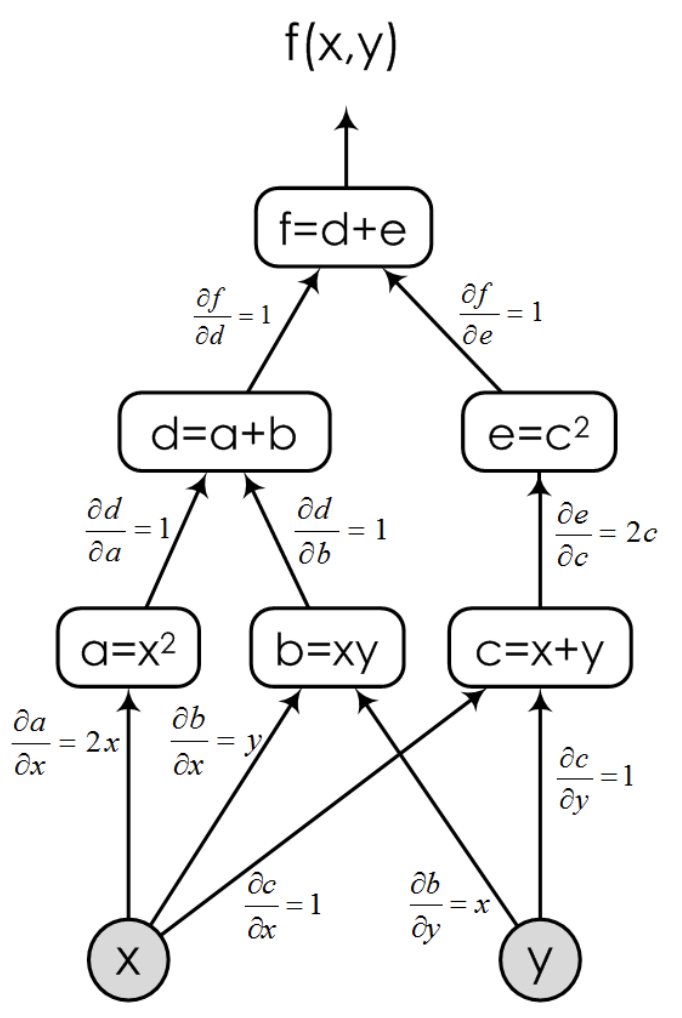

In PyTorch, computational graphs are implicit, but the concept of a graph still can help understand how it works.

#### Functions 
Functions - operations on tensors, which are combined in a computation graph.

In [7]:
class MulConstant(torch.autograd.Function):
    # forward computes the function using inputs.
    @staticmethod
    def forward(ctx, 
                tensor: torch.FloatTensor, 
                constant: float) -> torch.FloatTensor:
        # ctx is a context object that can be used to stash information
        # for backward computation.
        ctx.constant = constant
        # Here we store constant in the context. Field name 'constant'
        # is arbitrary and we can use any name we want.
        return tensor * constant

    # backward compute derivatives during backward propagation. 
    # Its inputs are gradients of outputs.
    @staticmethod
    def backward(ctx, grad_output: torch.FloatTensor) -> torch.FloatTensor:
        # We return as many input gradients as there were arguments.
        # Gradients of non-Tensor arguments to forward must be None.
        return grad_output * ctx.constant, None

In [8]:
class Mul(torch.autograd.Function):
    @staticmethod
    def forward(ctx, 
                tensor1: torch.FloatTensor, 
                tensor2: torch.FloatTensor) -> torch.FloatTensor:
        ctx.tensor1 = tensor1
        ctx.tensor2 = tensor2
        # We store values of both tensors as we will need them for 
        # backward propogation.
        return tensor1 * tensor2

    @staticmethod
    def backward(ctx, grad_output: torch.FloatTensor) -> torch.FloatTensor:
        # This time both inputs are tensors, so we compute gradients 
        # for both of them.
        return grad_output * ctx.tensor2, grad_output * ctx.tensor1

Usually, there is no need to define functions, as PyTorch already has an excellent built-in function library. Most of the functions you'll need are already there or can be expressed as a composition of built-in functions. You can look for built-in functions in torch documentation here: https://pytorch.org/docs/stable/torch.html.

In [9]:
MulConstant.apply(x, 3)

tensor([3., 6.])

Usually it's used like this:

In [10]:
mul_constant = MulConstant.apply
mul_constant(x, 3)

tensor([3., 6.])

Using built-in functions:

In [11]:
torch.mul(x, 3)

tensor([3., 6.])

Operator syntax:

In [12]:
x * 3

tensor([3., 6.])

We can define new function, using python and built-in function library.



In [13]:
def power(tensor: torch.FloatTensor, exponent: int) -> torch.FloatTensor:
  result = torch.ones_like(tensor)
  for i in range(0, exponent):
    result *= tensor # same as result = torch.mul(result, tensor)
  return result

In [14]:
power(x, 2)

tensor([1., 4.])

In [15]:
x = torch.tensor(2.0, requires_grad=True) # requires_grad shows that this is a graph "input"
y = torch.tensor(2.0, requires_grad=True)
a = x ** 2
b = x * y
c = x + y
d = a + b
e = c ** 2
f = d + e
f

tensor(24., grad_fn=<AddBackward0>)

Foward computation happened automatically while we were building the graph. `grad_fn` means that `f` is not just a tensor but has a computational graph associated with it (AddBackward implies that the "topmost" operation of this graph is Add). And we can backward propagate to compute gradients.

### Autograd

The core of all ML frameworks is the calculation of derivatives using backward propagation.

In [16]:
f.backward()

In [17]:
x.grad

tensor(14.)

In [18]:
y.grad

tensor(10.)

Can we do this again?

In [19]:
#f.backward()

Graph was already removed. Torch optimizes memory consumption and removes computational graph as soon as it is backward-propagated. Fortunately, error message is pretty clear, we can retain graph, by specifying `retain_graph=True` argument.

In [20]:
x = torch.tensor(2.0, requires_grad=True) # requires_grad shows that this is a graph "input"
y = torch.tensor(2.0, requires_grad=True)
a = x ** 2
b = x * y
c = x + y
d = a + b
e = c ** 2
f = d + e
f

tensor(24., grad_fn=<AddBackward0>)

In [21]:
f.backward(retain_graph=True)

In [22]:
x.grad

tensor(14.)

In [23]:
f.backward(retain_graph=True) 

In [24]:
x.grad

tensor(28.)

Gradient is `28`? Torch does not "clean" gradient value automatically (we'll find this pretty usefull later), so we must clean it manually.

In [25]:
x.grad = torch.tensor(0.0)

In [26]:
f.backward() 

In [27]:
x.grad

tensor(14.)

We can use this to compute gradients of any compositional function.

In [28]:
def f(x: torch.FloatTensor, y: torch.FloatTensor) -> torch.FloatTensor:
  a = x ** 2
  b = x * y
  c = x + y
  d = a + b
  e = c ** 2
  return d + e

In [29]:
x.grad = torch.tensor(0.0)
f(x, y).backward()
x.grad

tensor(14.)

The graph is rebuild each time we call the function, so we do not need to retain gradients.

In [30]:
x.grad = torch.tensor(0.0)
f(x, y).backward()
x.grad

tensor(14.)

# Assignment [10]

* 30% - Home work asigment [~ 10 points a day, ~ 120 total]

* 20% - Mid term test

* 20% - Final Exam

* 30% - Course projects (can be replaced by bonus homework)

## Due to 10AM, 19.05.2020

##1. Power function [5] 

Implement int power of FloatTensor autograd function, using addition and multiplication. [3]

In [31]:
class Power(torch.autograd.Function):
    @staticmethod
    def forward(ctx, 
                tensor: torch.FloatTensor, 
                exponent: int) -> torch.FloatTensor:
        ctx.tensor = tensor
        ctx.exponent = exponent
        result = torch.ones_like(tensor)
        for i in range(0, exponent):
            result *= tensor
        return result 

    @staticmethod
    def backward(ctx, grad_output: torch.FloatTensor) -> torch.FloatTensor:
        grad_input = grad_output.clone()
        grad_output_derivative = ctx.exponent * ctx.tensor ** (ctx.exponent - 1)
        grad_input = grad_output * grad_output_derivative
        return grad_input, None

Test that it is correct:

In [32]:
Power.apply(torch.tensor([1, 2, 3]), 0)

tensor([1, 1, 1])

In [33]:
Power.apply(torch.tensor([1, 2, 3]), 0) == torch.tensor([1,1,1])

tensor([True, True, True])

In [34]:
assert(torch.all(Power.apply(torch.tensor([1, 2, 3]), 0) == torch.tensor([1,1,1])))
# Note that tensors comparision returns tensor with elementwise comparisions
# [1,2,3] == [1,1 1] returns [True, False, False].
# Thus we use torch.all to reduce it to a single boolean value.
# torch.all(x) is true only if all elements of x are True.

In [35]:
assert(torch.all(Power.apply(torch.tensor([1, 2, 3]), 2) == torch.tensor([1,4,9])))

Test that gradients are computed correctly (even for composite functions using Power). [1]

In [36]:
x = torch.tensor([0.0, 1.0], requires_grad=True)
f = power(x, 3)
f

tensor([0., 1.], grad_fn=<MulBackward0>)

In [37]:
g = torch.sum(f)
g

tensor(1., grad_fn=<SumBackward0>)

In [38]:
g.backward()
print(x.grad)

tensor([0., 3.])


In [39]:
x1 = torch.tensor([0.0, 1.0], requires_grad=True)
f1 = Power.apply(x1, 3)

In [40]:
g1 = torch.sum(f1)
g1

tensor(1., grad_fn=<SumBackward0>)

In [41]:
g1.backward()
print(x1.grad)

tensor([0., 3.])


Add more tests/assertion to check the edge cases.

In [42]:
torch.all(f == f1)

tensor(True)

In [43]:
assert(torch.all(f == f1))

In [44]:
assert(torch.all(g == g1))

In [45]:
assert(torch.all(x.grad == x1.grad))

By defining `Power` class we introduced a new building block which can be used in computational graph.
Computational graph for `Power.apply(x, 3)` has just three vertices, `x`, constant `3` and `Power`.
We introduce function `power` in the class. 
How does computational graph for `power(x, 3)` look? 
(hint: we used only two types of building blocks, `*` and `torch.ones_like`) [1]

- ANSWER

`torch.ones_like` simply returns a copy of the tensor with the same dimesions. After that, in order to exponent the initial tensor, we multiply the initial tensor with ones by the tensor itself (which can be compared to power 1).

Then according to the value of the integer exponent, we keep multiplying this with the tensor itself in a loop.

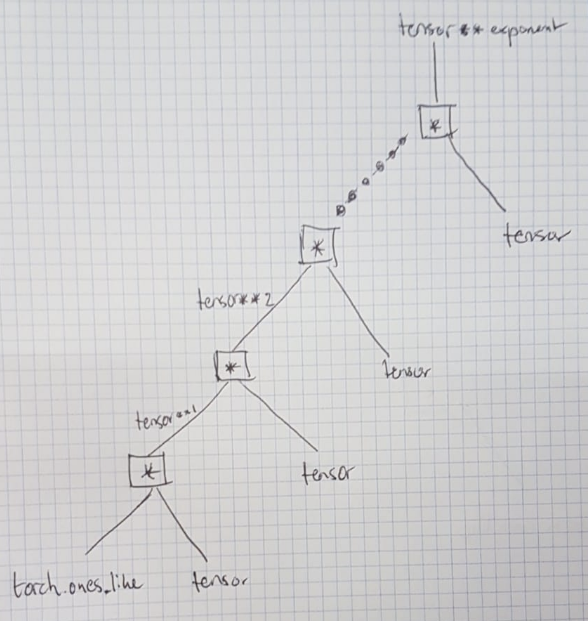

You can replace the power by a for loop, which just multiplies itself by the level of the exponent. See the following function:

In [46]:
class Power(torch.autograd.Function):
    @staticmethod
    def forward(ctx, 
                tensor: torch.FloatTensor, 
                exponent: int) -> torch.FloatTensor:
        
        # Save for backward pass
        ctx.tensor = tensor
        ctx.exponent = exponent
        
        # Initialization
        result = torch.ones_like(tensor)
        
        # Multiplying loop
        for i in range(0, exponent):
            result *= tensor
        return result 

    @staticmethod
    def backward(ctx, grad_output: torch.FloatTensor) -> torch.FloatTensor:
        grad_input = grad_output.clone()
        grad_output_derivative = ctx.exponent * ctx.tensor ** (ctx.exponent - 1)
        grad_input = grad_output * grad_output_derivative
        return grad_input, None

## 2. Polynom [5]

Find zero of the following polynom with up to five decimal places:

In [47]:
def poly(x: torch.FloatTensor) -> torch.FloatTensor:
  return x**7 + 5 * x**3  + 17 * x -9

Using binary search https://en.wikipedia.org/wiki/Binary_search_algorithm [1]:

In [48]:
from typing import Callable

In [49]:
def bin_search_find_zero(poly: Callable[[torch.FloatTensor], 
                                        torch.FloatTensor]) -> torch.FloatTensor:
    a = -1 
    b = 1
    tol = 10**-10
    
    while (b - a)/2.0 > tol:
        midpoint = (a + b)/2.0
        if poly(midpoint) == 0:
            return(midpoint)             
        elif poly(a)*poly(midpoint) < 0:       
            b = midpoint
        else:
            a = midpoint
    return(midpoint)

Test, first method: Binary search

In [50]:
%%time 
result = bin_search_find_zero(poly)
assert(result - 0.49361 < 10^5)

CPU times: user 29 µs, sys: 5 µs, total: 34 µs
Wall time: 35 µs


Using Newton's method https://en.wikipedia.org/wiki/Newton%27s_method [2]
(hint: use backward to compute derivatives):


In [52]:
def newton_find_zero(poly: Callable[[torch.FloatTensor], 
                                    torch.FloatTensor],
                                    ) -> torch.FloatTensor:
    tol = 10**-7
    dx = tol
    x = 2
    while True:
        
        num = poly(x)
        
        x = torch.autograd.Variable(torch.Tensor([x]),requires_grad=True)
        poly(x).backward()
        den = x.grad
        
#         print('------------- LOOP ------------', i)
#         print('current point: ', x.item())
#         print('df: ', num)
#         print('dff: ', den)
        
        xnew = x.item() - ( num / den.item() )
        if abs(x.item() - xnew) < tol:
            return xnew
            break
            
#         print('current precisiion: ', abs(x.item() - xnew))
#         print('tolerance: ', tol)
#         print('should I break?', abs(x.item() - xnew) < tol)
            
        x = xnew

Question: how can you be sure that the answer is correct up to five decimal places? [1]

- Set a certain tolerance as exit condition.

Test, which of this methods is faster. [1]
You can do this using `%%time` notebook command.



In [53]:
%%time
result = newton_find_zero(poly)
assert(result - 0.49361 < 10^5)

CPU times: user 1.09 ms, sys: 0 ns, total: 1.09 ms
Wall time: 905 µs


Test, which of this methods is faster. [1]
You can do this using `%%time` notebook command.



In [54]:
time_res1 = %timeit -n1 -r1 -o sum(range(1000000))
result = bin_search_find_zero(poly)
print(time_res1.average)

12.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
0.01228172500123037


In [1]:
time_res2 = %timeit -n1 -r1 -o sum(range(1000000))
result = newton_find_zero(poly)
print(time_res2.average)

16.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


NameError: name 'newton_find_zero' is not defined

In [56]:
print('After one million testssss......')
if time_res1.average > time_res2.average:
    print('THE WINNER IS BINARY SEARCH!!!!!')
else:
    print('THE WINNER IS NEWTONS METHOD!!!!!!!!')

After one million testssss......
THE WINNER IS BINARY SEARCH!!!!!
